In [1]:
import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from matplotlib import gridspec
import matplotlib.dates as md
from sklearn.model_selection import LeaveOneOut
os.environ['PROJ_LIB'] = '/home/ehsan/anaconda3/share/proj'
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import glob
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
def ranker(string):
    
    l = string.split("+")
    N = len(l)*100
    
    P = 0
    for _ in l: 
        P+=sorter2(_[:-3])
        
    return P+N
    
    

def sorter2(param):
    
    if param == 'ELE':
        return 1
    elif param == 'ELElin':
        return 2
    elif param == 'CDI':
        return 3
    elif param == 'rf':
        return 4    
    elif param == 'RF':
        return 5
    elif param == 'RFF':
        return 7
    elif param == 'LAI':
        return 10
    elif param == 'ALB':
        return 10
    elif param == 'TPI':
        return 12
    elif param == 'WSP':
        return 17
    return 0    
    
    
def sorter(param):
    
    if param == 'ELEV.m.':
        return 'ELE', 0
    if param == 'ELEV.m..linear':
        return 'ELElin', 0
    if param == 'dem':
        return 'DEM', 0    
    if param == 'LON':
        return 'LON', 1
    if param == 'LAT':
        return 'LAT', 2
    elif param == 'RF':
        return 'RFF', 4
    elif param == 'rf':
        return 'rf', 5
    elif param == 'coastDist':
        return 'CDI', 3
    elif param == 'lai':
        return 'LAI', 6
    elif param == 'albedo':
        return 'ALB', 7
    elif param == 'tpi':
        return 'TPI', 8
    elif param == 'windSpeed':
        return 'WSP', 9
    return None, None

def sorterL(params):
    
    N = 10   # the number of all possible parameters
    n = len(params)
    l = [None]*N
    
    for p in params:
        try:
            p_, i = sorter(p)
            l[i] = p_
                          
        except:
            pass
        
    
    return l
    

def l2str(l):
    
    s = []
    n = len(l)
    for _ in l:
        if not _ is None:
            s.append(_)
    
    strg = ""
    for _ in s[:-1]:
        strg+=_+"+"
    strg+=s[-1]
         
    return strg

In [3]:
def generateStats(files, column):
    
    mList = []

    for model in files:

        df = pd.read_csv(model, sep=',')

        mean = df[[column]].describe().loc["mean"].values[0]
        std  = df[[column]].describe().loc["std"].values[0]

        params = model.split("_")[3:-1]
        string = l2str(sorterL(params))

        mList.append((ranker(string), string, mean, std))

    mList.sort(key=lambda l: l[0])

    return mList



In [4]:
def islandCode(code):
    
    if code == 'OA':
        return 'Oahu'
    elif code == 'MN':
        return 'Maui+'
    elif code == 'BI':
        return 'Big Island'
    elif code == 'KA':
        return 'Kauai'

In [5]:
def panelPlot(ax, files, column, title, showLabels=False, fmt='o', indDict=None):
    
    mList = generateStats(files, column)
    N = len(mList)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    colors += ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    colors*=10
    
    for i in range(N):
        item = mList[i]
        if indDict is None:
            ax.errorbar(item[2], i, xerr=item[3], fmt=fmt, color=colors[i], mfc='white', ms=8)
        else:
            ax.errorbar(item[2], indDict[item[1]], xerr=item[3]*0, fmt=fmt, color=colors[i], mec='k')

    if showLabels and indDict is None:
        ax.set_yticks(range(N))
        ax.set_yticklabels([l[1]+'    '+str(i) for i, l in enumerate(mList)] , rotation=0, fontsize=10)
    
    if indDict is None:
        ax.set_xlabel(column, fontsize=16)
        ax.set_title(title, fontsize=18)
        ax.axvline(x=mList[0][2], ls=":") 
        
        fontsize = 14
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
#         for tick in ax.yaxis.get_major_ticks():
#             tick.label.set_fontsize(fontsize) 
    
    return mList

In [6]:
def make_indDict(mList):
    
    indDict = {}
    for i, item in enumerate(mList):
        indDict[item[1]] = i    
    
    return indDict

In [7]:
def rowPlot(axList, code, mode, template, fmt='o', indDict=None, show=True):

    island = islandCode(code)
    
    print(template+mode+'*'+code+'*csv')
    files = glob.glob(template+mode+'*'+code+'*csv')
    title = r'$T_{'+mode+'}$'+' ('+island+')'

    column = "MAE"; ax=axList[0]
    mList= panelPlot(ax, files, column, title, showLabels=show, fmt=fmt, indDict=indDict)
    ax.set_xlabel(column+'  ['+r'$^o$'+'C]', fontsize=16)
    try:
        panelPlot(ax, files, "MAE_loo", title, fmt='o', indDict=make_indDict(mList))
    except:
        pass
    ax.set_xlim(0.2, 1.5)

#     column = "RMSE"; ax=axList[1]
#     panelPlot(ax, files, column, title, fmt=fmt, indDict=indDict)
#     ax.set_xlabel(column+'  ['+r'$^o$'+'C]', fontsize=16)
#     try:
#         panelPlot(ax, files, "RMSE_loo", title, fmt='o', indDict=make_indDict(mList))
#     except:
#         pass
#     ax.set_xlim(0.2, 1.7)
    
#     column = "R2"; ax=axList[2]
#     panelPlot(ax, files, column, title, fmt=fmt, indDict=indDict)
#     ax.set_xlabel(r'$R^2$', fontsize=16)
#     try:
#         panelPlot(ax, files, "R2_loo", title, fmt='o', indDict=make_indDict(mList))
#     except:
#         pass
#     ax.set_xlim(0.2,1)
    
    column = "BIC"; ax=axList[1]
    panelPlot(ax, files, column, title, fmt=fmt, indDict=indDict)
    ax.set_xlabel(column, fontsize=14)
    try:
        panelPlot(ax, files, column+'_loo', title, fmt='o', indDict=make_indDict(mList))
    except:
        pass

#     column = "AIC"; ax=axList[4]
#     panelPlot(ax, files, column, title, fmt=fmt, indDict=indDict)
#     try:
#         panelPlot(ax, files, column+'_loo', title, fmt='o', indDict=make_indDict(mList))
#     except:
#         pass    
#     ax.set_xlabel(column, fontsize=14)
    
    column = "AICc"; ax=axList[2]
    panelPlot(ax, files, column, title, fmt=fmt, indDict=indDict)
    try:
        panelPlot(ax, files, column+'_loo', title, fmt='o', indDict=make_indDict(mList))
    except:
        pass
    ax.set_xlabel(column, fontsize=14)
    
    if indDict is None:
        indDict = make_indDict(mList)
    
    return indDict

In [8]:
LIN = "LIN2/LIN_T"

LIN2/LIN_Tmin*OA*csv
LIN2/LIN_Tmax*OA*csv


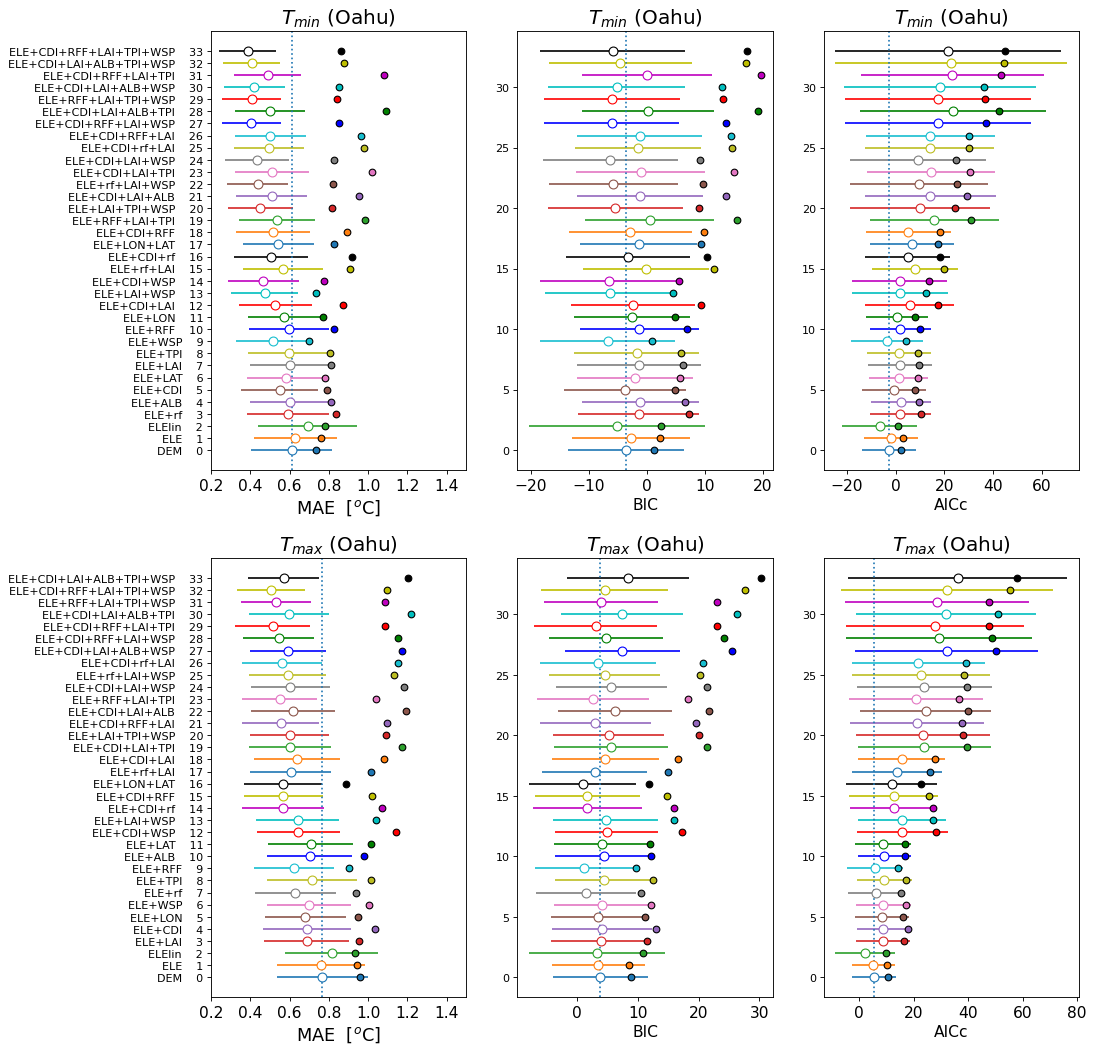

In [9]:
fig = plt.figure(figsize=(14,16), dpi=80)
TOPax = [fig.add_subplot(2, 3, i) for i in range(1,4)]
BOTax = [fig.add_subplot(2, 3, i) for i in range(4,7)]

# fig = plt.figure(figsize=(10, 7), dpi=80)
# TOPax = [fig.add_subplot(1, 2, 1)]
# BOTax = [fig.add_subplot(1, 2, 2)]

island = 'OA'

indDict = rowPlot(TOPax, island, 'min', LIN, show=True)  # show sets if we want the name of models on left
indDict = rowPlot(BOTax, island, 'max', LIN, show=True)

LIN2/LIN_Tmin*MN*csv
LIN2/LIN_Tmax*MN*csv


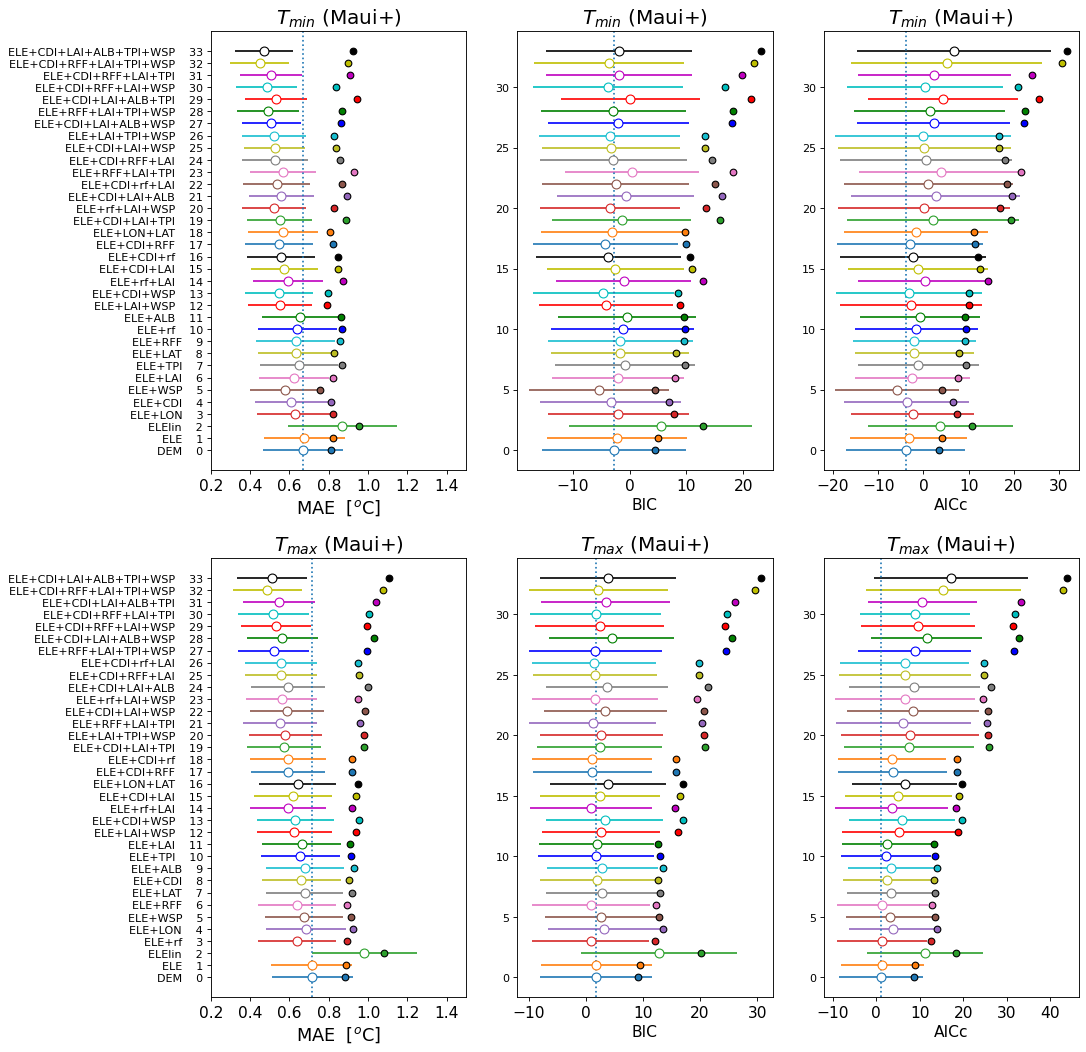

In [10]:
fig = plt.figure(figsize=(14,16), dpi=80)
TOPax = [fig.add_subplot(2, 3, i) for i in range(1,4)]
BOTax = [fig.add_subplot(2, 3, i) for i in range(4,7)]

# fig = plt.figure(figsize=(10, 7), dpi=80)
# TOPax = [fig.add_subplot(1, 2, 1)]
# BOTax = [fig.add_subplot(1, 2, 2)]

island = 'MN'

indDict = rowPlot(TOPax, island, 'min', LIN, show=True)  # show sets if we want the name of models on left
indDict = rowPlot(BOTax, island, 'max', LIN, show=True)

LIN2/LIN_Tmin*BI*csv
LIN2/LIN_Tmax*BI*csv


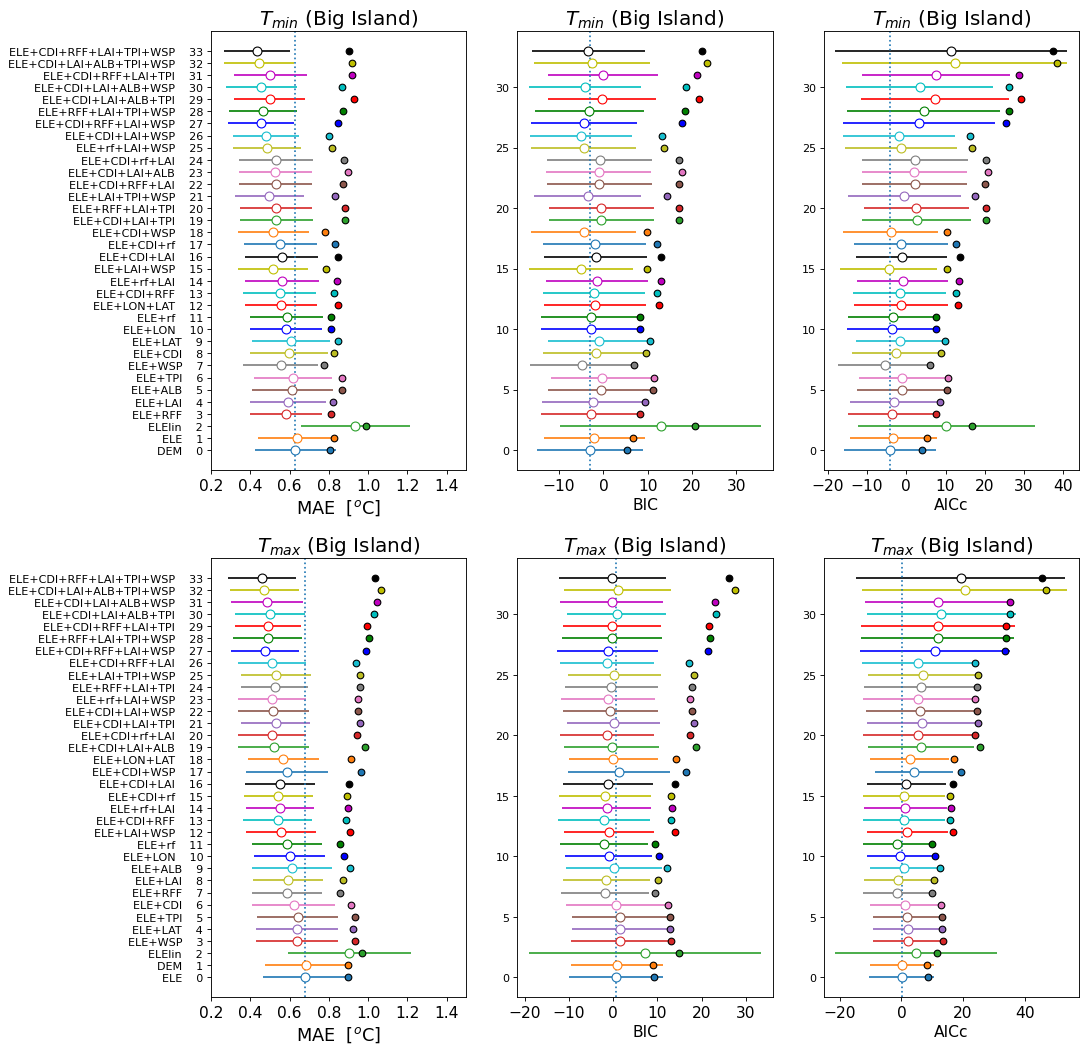

In [11]:
fig = plt.figure(figsize=(14,16), dpi=80)
TOPax = [fig.add_subplot(2, 3, i) for i in range(1,4)]
BOTax = [fig.add_subplot(2, 3, i) for i in range(4,7)]

# fig = plt.figure(figsize=(10, 7), dpi=80)
# TOPax = [fig.add_subplot(1, 2, 1)]
# BOTax = [fig.add_subplot(1, 2, 2)]

island = 'BI'

indDict = rowPlot(TOPax, island, 'min', LIN, show=True)  # show sets if we want the name of models on left
indDict = rowPlot(BOTax, island, 'max', LIN, show=True)

LIN2/LIN_Tmin*KA*csv
LIN2/LIN_Tmax*KA*csv


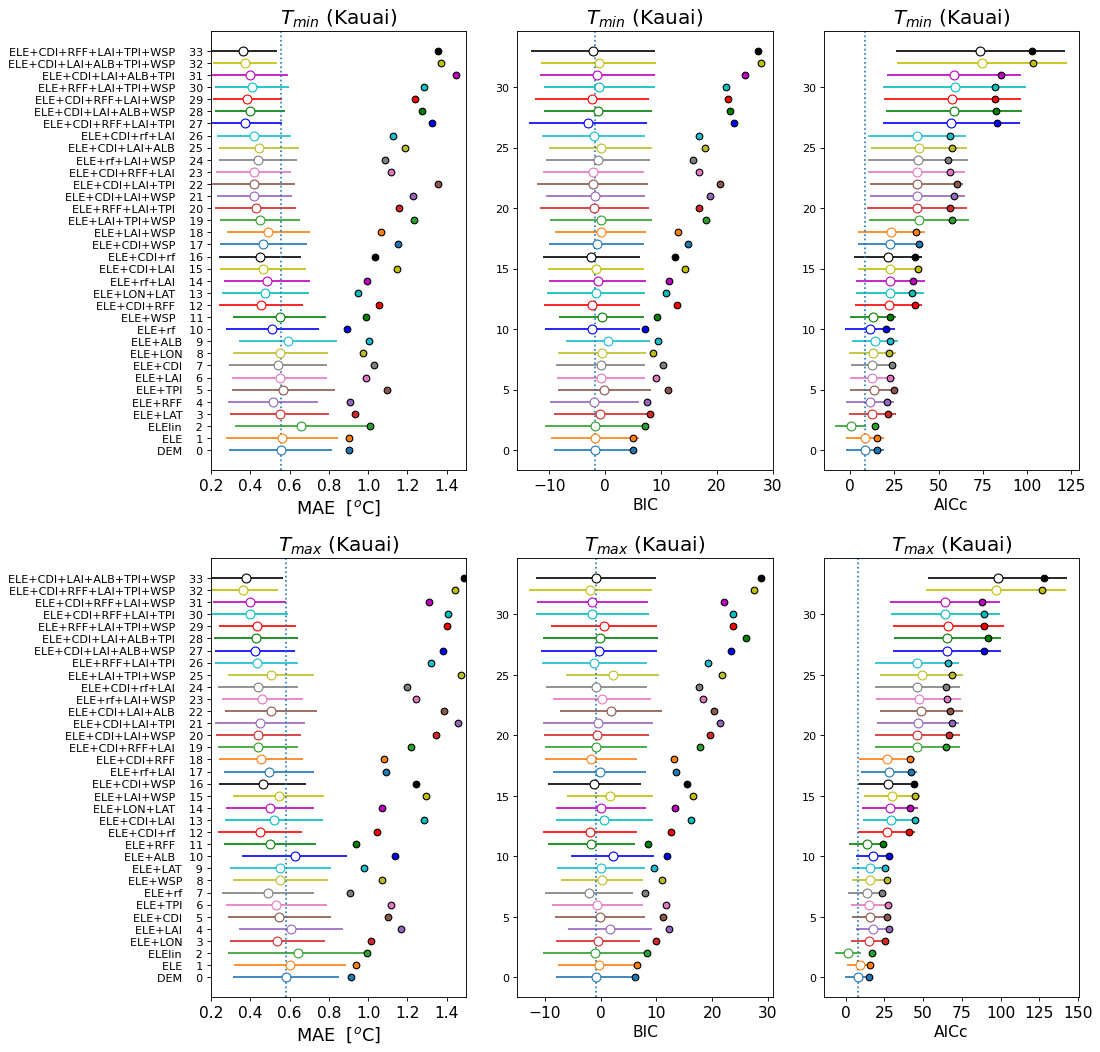

In [12]:
fig = plt.figure(figsize=(14,16), dpi=80)
TOPax = [fig.add_subplot(2, 3, i) for i in range(1,4)]
BOTax = [fig.add_subplot(2, 3, i) for i in range(4,7)]

# fig = plt.figure(figsize=(10, 7), dpi=80)
# TOPax = [fig.add_subplot(1, 2, 1)]
# BOTax = [fig.add_subplot(1, 2, 2)]

island = 'KA'

indDict = rowPlot(TOPax, island, 'min', LIN, show=True)  # show sets if we want the name of models on left
indDict = rowPlot(BOTax, island, 'max', LIN, show=True)